In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
# Runtime type
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.4.1+cu121  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.ToTensor(),              # Convert to tensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize
])


val_transforms = transforms.Compose([
        transforms.Resize(256),             # Resize the shorter side to 256
        transforms.CenterCrop(224),         # Crop the center 224x224
        transforms.ToTensor(),              # Convert to tensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize
])


image_trainsets = datasets.ImageFolder(root = "/content/drive/MyDrive/data_ai/geoguess/train", transform=train_transforms)
image_valsets = datasets.ImageFolder(root = "/content/drive/MyDrive/data_ai/geoguess/test", transform=val_transforms)

trainloader = torch.utils.data.DataLoader(image_trainsets, batch_size = BATCH_SIZE, shuffle = True, num_workers=4, pin_memory=True)
valloader = torch.utils.data.DataLoader(image_valsets, batch_size = BATCH_SIZE, shuffle = False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
for (X_train, y_train) in trainloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


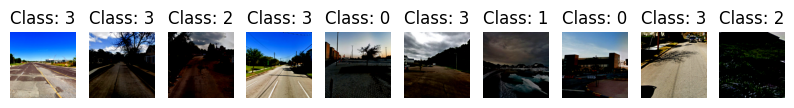

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))
# Print pictures for test

In [8]:
import torchvision.models as models
model = models.resnet50(pretrained=True)
# Use ResNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.3MB/s]


In [9]:
for parameter in model.parameters():
    parameter.requires_grad = True
    # Update the pre-trained model parameters

In [10]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 4),
)
model = model.to(DEVICE)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(model.parameters(), lr = 0.0001)

In [12]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [13]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE, dtype=torch.float)
            label = label.to(DEVICE, dtype=torch.long)
            output = model(image).squeeze(dim=1)
            test_loss += criterion(output, label).item()

            pr = torch.softmax(output, dim=1)
            _, predicted = torch.max(pr, 1)

            correct += (predicted.cpu() == label.cpu()).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [14]:
for epoch in range(1, EPOCHS + 1):
    train(model, trainloader, optimizer, log_interval = 6)
    valid_loss, valid_accuracy = evaluate(model, valloader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/960 (0%)]	Train Loss: 1.419510
Train Epoch: 1 [192/960 (20%)]	Train Loss: 1.614822
Train Epoch: 1 [384/960 (40%)]	Train Loss: 1.440050
Train Epoch: 1 [576/960 (60%)]	Train Loss: 1.383681
Train Epoch: 1 [768/960 (80%)]	Train Loss: 1.323693

[EPOCH: 1], 	Test Loss: 1.2229, 	Test Accuracy: 48.25 % 

Train Epoch: 2 [0/960 (0%)]	Train Loss: 1.241315
Train Epoch: 2 [192/960 (20%)]	Train Loss: 1.003119
Train Epoch: 2 [384/960 (40%)]	Train Loss: 0.962948
Train Epoch: 2 [576/960 (60%)]	Train Loss: 1.078934
Train Epoch: 2 [768/960 (80%)]	Train Loss: 0.853040

[EPOCH: 2], 	Test Loss: 0.6510, 	Test Accuracy: 88.75 % 

Train Epoch: 3 [0/960 (0%)]	Train Loss: 0.636670
Train Epoch: 3 [192/960 (20%)]	Train Loss: 0.677433
Train Epoch: 3 [384/960 (40%)]	Train Loss: 0.586444
Train Epoch: 3 [576/960 (60%)]	Train Loss: 0.529400
Train Epoch: 3 [768/960 (80%)]	Train Loss: 0.535672

[EPOCH: 3], 	Test Loss: 0.3492, 	Test Accuracy: 92.25 % 

Train Epoch: 4 [0/960 (0%)]	Train Loss: 0.471417
Tra